In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader

# Import your custom modules
# If these fail, ensure the .py files are in the same folder as this notebook
from models.MST import MST_GNN
from dataset import InMemoryDynamicSP100
from models.train import train

# Setup Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")

Using Device: cuda


In [16]:
# Data Configuration
PAST_WINDOW = 30       # Look-back window (Delta t)
FUTURE_WINDOW = 1      # Prediction horizon
BATCH_SIZE = 32

# MSCMG Graph Generation Params
GRAPH_RETURN_THRESH = 0.005  # 1% movement threshold (increased from 0.0009 - was TOO sparse)
LABEL_RETURN_THRESH = 0.005  # 1% movement threshold for labels
MAX_DIST = 5           # Max Manhattan distance for edges (reduced from 8 to be more selective)

# Model Configuration
INPUT_FEATURES = 9     # Check your values.csv (e.g., Open, Close, High, Low...)
HIDDEN_SIZE = 64
GRAPH_LAYERS = 3       # 'M' layers
CROSS_LAYERS = 2       # 'C' layers
LEARNING_RATE = 0.001  # Increased from 0.0005 to speed up convergence

NUM_EPOCHS = 100

In [ ]:
print("Initializing Dataset...")

# We set force_process=True to regenerate with new 3-class labels
# After first run, you can set it back to False to load from disk
dataset = InMemoryDynamicSP100(
    root="./data", 
    values_file_name="values_crypto.csv",  # Use the crypto data file
    past_window=PAST_WINDOW, 
    future_window=FUTURE_WINDOW,
    graph_return_threshold=GRAPH_RETURN_THRESH,
    label_return_threshold=LABEL_RETURN_THRESH,
    max_dist_threshold=MAX_DIST,
    force_process=True  # Set to True to regenerate with 3-class labels
)

print(f"Total Samples: {len(dataset)}")
print(f"Feature Shape (Node, Time, Feat): {dataset[0].x.shape}")
print(f"Sample Label (should be 0, 1, or 2): {dataset[0].y}")

Initializing Dataset...
Processing Dynamic Graphs (MSCMG)...
Loading raw data from: data/raw/raw/values_crypto.csv


Processing...


FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/raw/values_crypto.csv'

In [ ]:
# Calculate Class Weights to Handle Imbalance
# This ensures the loss penalizes misclassification of minority classes more heavily
from collections import Counter

# Get all labels from dataset (note: labels are node-level, so we flatten them)
all_labels = []
for i in range(len(dataset)):
    all_labels.extend(dataset[i].y.cpu().numpy().flatten().tolist())

class_counts = Counter(all_labels)

print("--- Class Distribution in Full Dataset ---")
print(f"Downward (0): {class_counts[0]} samples")
print(f"Neutral  (1): {class_counts[1]} samples")
print(f"Upward   (2): {class_counts[2]} samples")
print(f"Total: {sum(class_counts.values())} samples")

# Calculate weights: inverse of class frequency
# weight = total_samples / (num_classes * samples_per_class)
num_classes = 3
total_samples = len(all_labels)
class_weights = torch.tensor([
    total_samples / (num_classes * class_counts[i]) 
    for i in range(num_classes)
], dtype=torch.float)

# Normalize weights so they average to 1.0 (optional but good practice)
class_weights = class_weights / class_weights.mean()

print("\n--- Class Weights (normalized) ---")
print(f"Downward weight: {class_weights[0]:.4f}")
print(f"Neutral weight:  {class_weights[1]:.4f}")
print(f"Upward weight:   {class_weights[2]:.4f}")
print("\nNote: Minority classes (Downward) get higher weights to compensate for fewer samples")

--- Class Distribution in Full Dataset ---
Downward (0): 22059 samples
Neutral  (1): 8000 samples
Upward   (2): 21291 samples
Total: 51350 samples

--- Class Weights (normalized) ---
Downward weight: 0.6259
Neutral weight:  1.7257
Upward weight:   0.6484

Note: Minority classes (Downward) get higher weights to compensate for fewer samples


In [ ]:
# FEATURE NORMALIZATION - CRITICAL FOR MODEL LEARNING
# Features have vastly different scales (price ~180 vs returns ~0.001)
# This causes the model to ignore smaller features

print("\n" + "="*60)
print("FEATURE NORMALIZATION")
print("="*60)

from sklearn.preprocessing import StandardScaler
import torch_geometric.transforms as T

# Collect all features
all_features = []
for i in range(len(dataset)):
    # Shape: (num_nodes, time, features)
    x = dataset[i].x.numpy()
    # Flatten to (num_nodes*time, features)
    all_features.append(x.reshape(-1, x.shape[-1]))

all_features = np.vstack(all_features)
print(f"Collected {all_features.shape[0]} samples, {all_features.shape[1]} features")

# Fit StandardScaler on training data only (to avoid data leakage)
train_size_samples = int(0.8 * len(dataset))
train_features_indices = []
for i in range(train_size_samples):
    x = dataset[i].x.numpy()
    train_features_indices.append(x.reshape(-1, x.shape[-1]))
train_features_all = np.vstack(train_features_indices)

scaler = StandardScaler()
scaler.fit(train_features_all)

print("\nScaling Statistics:")
print(f"Mean: {scaler.mean_}")
print(f"Std:  {scaler.scale_}")

# Apply scaler to all dataset samples
for i in range(len(dataset)):
    x = dataset[i].x.numpy()  # Shape: (nodes, time, features)
    original_shape = x.shape
    
    # Flatten, scale, reshape
    x_flat = x.reshape(-1, x.shape[-1])
    x_scaled = scaler.transform(x_flat)
    x_scaled = x_scaled.reshape(original_shape)
    
    # Update in dataset
    dataset[i].x = torch.tensor(x_scaled, dtype=torch.float)

print("✅ Features normalized (mean=0, std=1 based on training data)")
print("="*60 + "\n")


FEATURE NORMALIZATION
Collected 1540500 samples, 14 features

Scaling Statistics:
Mean: [ 1.29682955e+03  9.07954834e-04 -1.18872323e-04  1.53810068e-02
  1.01051196e-03 -7.99068075e-02 -3.52582329e-01  6.04645459e-03
  4.89698963e-01  1.42637686e+01  6.11596663e-02  8.94215801e-04
  1.43689553e-02  1.58650389e-02]
Std:  [9.08739993e+03 4.61007936e-02 4.50286852e-02 2.26558804e+00
 3.18679557e+00 4.65540751e+00 6.55920940e+00 1.01629967e+00
 1.22303173e-01 2.68543094e+02 4.33587936e-02 4.61029734e-02
 1.65413521e-02 1.97396622e-02]
✅ Features normalized (mean=0, std=1 based on training data)



In [ ]:
# Create a temporary loader to grab one batch
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
sample_batch = next(iter(loader))

print("--- Batch Inspection ---")
print(f"Batch Size (Graphs): {BATCH_SIZE}")
print(f"Total Nodes in Batch: {sample_batch.num_nodes}") 
print(f"Input Features (x):   {sample_batch.x.shape}")
print(f"Edge Index shape:     {sample_batch.edge_index.shape}")
print(f"Target Labels (y):    {sample_batch.y.shape}")
print(f"Label Classes: {torch.unique(sample_batch.y).tolist()} (0=Down, 1=Neutral, 2=Up)")

# Visualize the graph density of the first sample in the batch
num_nodes_sample = dataset[0].num_nodes
num_edges_sample = dataset[0].num_edges
print(f"\nSingle Graph Stats -> Nodes: {num_nodes_sample}, Edges: {num_edges_sample}")

--- Batch Inspection ---
Batch Size (Graphs): 32
Total Nodes in Batch: 1600
Input Features (x):   torch.Size([1600, 30, 14])
Edge Index shape:     torch.Size([2, 4398])
Target Labels (y):    torch.Size([1600])
Label Classes: [0, 1, 2] (0=Down, 1=Neutral, 2=Up)

Single Graph Stats -> Nodes: 50, Edges: 430


In [ ]:
# 1. Get the actual feature count from the loaded dataset
# dataset[0].x is shape (Nodes, Time, Features) -> We want index 2
REAL_INPUT_FEATURES = dataset[0].x.shape[2] 
print(f"Dataset has {REAL_INPUT_FEATURES} features.")

# 2. Initialize Model with the CORRECT size
model = MST_GNN(
    in_features=REAL_INPUT_FEATURES, # <--- Use the dynamic value here!
    hidden_size=HIDDEN_SIZE,
    num_graph_layers=GRAPH_LAYERS,
    num_cross_layers=CROSS_LAYERS
).to(DEVICE)

print("Model initialized with correct input dimensions.")

Dataset has 14 features.
Model initialized with correct input dimensions.


In [ ]:
model.eval() # Set to eval mode for testing
with torch.no_grad():
    # Move batch to device
    sample_batch = sample_batch.to(DEVICE)
    
    # Run Model
    logits = model(sample_batch.x, sample_batch.edge_index)
    
    print(f"Output Logits Shape: {logits.shape}")
    
    # Check shape: Should be (Total_Nodes_In_Batch, 3) for 3-class classification
    assert logits.shape == (sample_batch.x.shape[0], 3), "Output shape mismatch! Expected (N, 3) for 3-class classification."
    print("✅ Forward pass successful!")

Output Logits Shape: torch.Size([1600, 3])
✅ Forward pass successful!


Starting Test Training (3 Epochs with Weighted Loss)...
Epoch 1 | Loss: 1.1009
Epoch 2 | Loss: 1.0928
Epoch 3 | Loss: 1.0837
✅ Training loop functional!


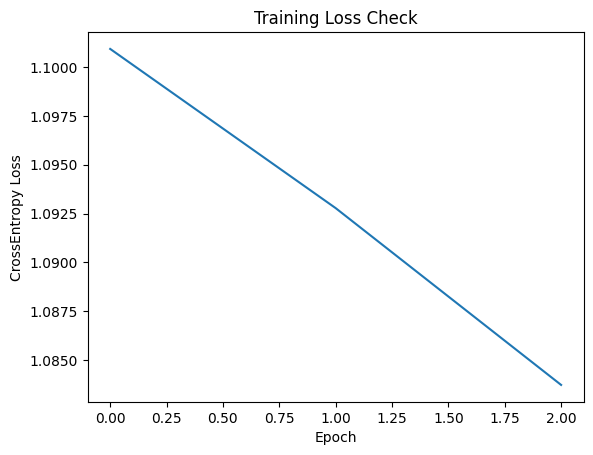

In [ ]:
# Setup Optimizer and Loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Use weighted loss to handle class imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))  # 3-class classification: 0=Down, 1=Neutral, 2=Up

# Split Train/Test (Simple split for testing)
train_size = int(0.8 * len(dataset))
train_set = dataset[:train_size]
test_set = dataset[train_size:]

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

print("Starting Test Training (3 Epochs with Weighted Loss)...")
model.train()

loss_history = []

for epoch in range(3):
    total_loss = 0
    steps = 0
    
    for batch in train_loader:
        batch = batch.to(DEVICE)
        optimizer.zero_grad()
        
        # 1. Forward
        logits = model(batch.x, batch.edge_index)
        
        # 2. Labels: 3-class labels (0=Downward, 1=Neutral, 2=Upward)
        # batch.y is already converted to class labels in dataset.py
        labels = batch.y.long()
        
        # 3. Backward
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        steps += 1
    
    avg_loss = total_loss / steps
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

print("✅ Training loop functional!")

# Plot Loss
plt.plot(loss_history)
plt.title("Training Loss Check")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.show()

In [ ]:
# 1. Define Loss and Optimizer
# We use CrossEntropyLoss with class weights to handle imbalance
# Minority classes (Downward) get higher weights to compensate for fewer samples
criterion = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 2. Setup DataLoaders
# Split data: 80% Train, 20% Test
train_size = int(0.8 * len(dataset))
train_set = dataset[:train_size]
test_set = dataset[train_size:]

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training on {len(train_set)} samples, Testing on {len(test_set)} samples.")
print("3-Class Classification: 0=Downward, 1=Neutral, 2=Upward")

# 3. Run the Training Loop
# Ensure you have the 'train' function defined from our previous step
print("Starting training with loss tracking...")
train_losses_epoch, test_losses_epoch = train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    num_epochs=NUM_EPOCHS,             # Adjust epochs as needed
    task_title="MST_GNN_Run_1",
    measure_acc=True
)
print("Training complete!")


Training on 821 samples, Testing on 206 samples.
3-Class Classification: 0=Downward, 1=Neutral, 2=Upward
Starting training with loss tracking...


Epochs: 100%|██████████| 100/100 [05:09<00:00,  3.10s/it, Batch=100.0%]

Training complete!


In [ ]:
torch.save(model.state_dict(), f"models/saved_models/UpDownTrend_MST_run1_crypto_{model.__class__.__name__}.pt")

Plotting training history...
Training Statistics:
Initial Train Loss: 0.9187
Final Train Loss:   0.6957
Initial Test Loss:  1.1698
Final Test Loss:    2.5968


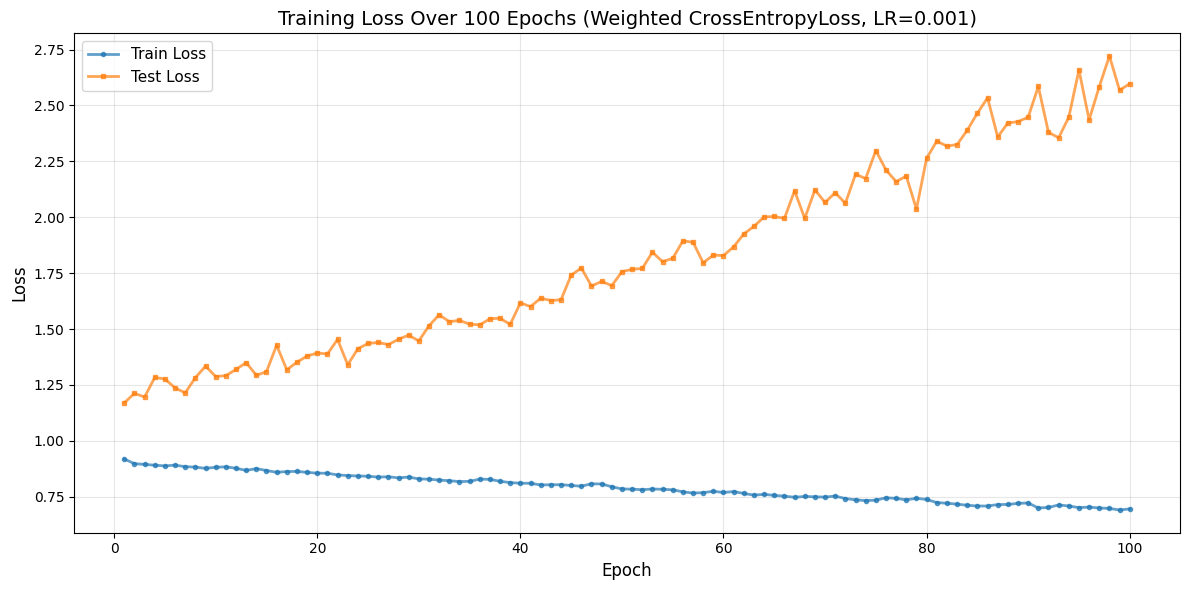

✅ Model saved to models/saved_models/UpDownTrend_MST_run1_crypto_MST_GNN.pt


In [ ]:
# Plot loss curves from training (no need to retrain!)
print("Plotting training history...")
print("=" * 60)

print("Training Statistics:")
print(f"Initial Train Loss: {train_losses_epoch[0]:.4f}")
print(f"Final Train Loss:   {train_losses_epoch[-1]:.4f}")
print(f"Initial Test Loss:  {test_losses_epoch[0]:.4f}")
print(f"Final Test Loss:    {test_losses_epoch[-1]:.4f}")

# Plot loss curves
plt.figure(figsize=(12, 6))
epochs_range = range(1, NUM_EPOCHS + 1)

plt.plot(epochs_range, train_losses_epoch, label='Train Loss', linewidth=2, marker='o', markersize=3, alpha=0.7)
plt.plot(epochs_range, test_losses_epoch, label='Test Loss', linewidth=2, marker='s', markersize=3, alpha=0.7)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title(f'Training Loss Over {NUM_EPOCHS} Epochs (Weighted CrossEntropyLoss, LR={LEARNING_RATE})', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save the model
torch.save(model.state_dict(), f"models/saved_models/UpDownTrend_MST_run1_crypto_{model.__class__.__name__}.pt")
print(f"✅ Model saved to models/saved_models/UpDownTrend_MST_run1_crypto_{model.__class__.__name__}.pt")


Evaluating on 206 test samples...
Unique classes found: [0 1 2]

             CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Downward       0.43      0.59      0.50      4470
     Neutral       0.15      0.13      0.14      1713
      Upward       0.43      0.27      0.33      4117

    accuracy                           0.39     10300
   macro avg       0.34      0.33      0.32     10300
weighted avg       0.38      0.39      0.37     10300

Total Accuracy: 0.3889


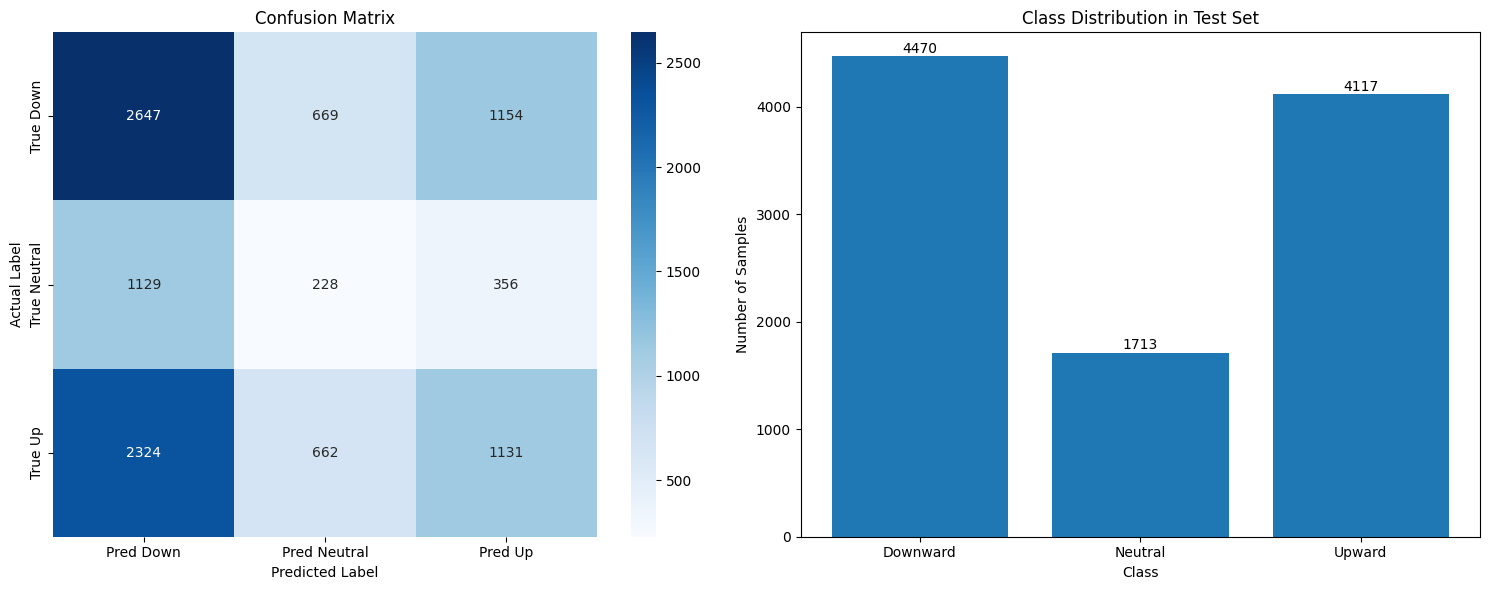

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch_geometric.loader import DataLoader

# --- 1. Setup Evaluation Data ---
# Re-create the test loader to ensure we are evaluating the correct split
# (Assumes 'dataset' is already loaded in memory from previous cells)
train_size = int(0.8 * len(dataset))
test_dataset = dataset[train_size:]
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Evaluating on {len(test_dataset)} test samples...")

# --- 2. Inference Function ---
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for data in loader:
            # Move data to GPU
            data = data.to(DEVICE)
            
            # Forward pass (Using the 3-arg signature we fixed earlier)
            # data.edge_weight is passed but ignored by the model logic
            logits = model(data.x, data.edge_index, data.edge_weight)
            
            # Softmax to get probabilities for each class
            probs = torch.softmax(logits, dim=1)
            
            # Get class predictions (argmax)
            preds = torch.argmax(probs, dim=1)
            
            # Labels are already class labels (0, 1, or 2)
            labels = data.y.long()
            
            # Store on CPU for plotting
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# --- 3. Run Inference ---
# If you want to load the specifically saved model file, uncomment the lines below:
model.load_state_dict(torch.load(f"models/saved_models/UpDownTrend_MST_run1_{model.__class__.__name__}.pt"))
model.to(DEVICE)

y_true, y_pred, y_prob = get_predictions(model, test_loader)

# Check unique classes in predictions
unique_classes = np.unique(np.concatenate([y_true, y_pred]))
print(f"Unique classes found: {unique_classes}")

# --- 4. Visualizations ---

# A. Classification Report
print("\n" + "="*50)
print("             CLASSIFICATION REPORT")
print("="*50)
# Use labels parameter to ensure consistent reporting
print(classification_report(y_true, y_pred, labels=[0, 1, 2], target_names=['Downward', 'Neutral', 'Upward'], zero_division=0))
print(f"Total Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# Setup Plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# B. Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred Down', 'Pred Neutral', 'Pred Up'],
            yticklabels=['True Down', 'True Neutral', 'True Up'])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('Actual Label')
axes[0].set_xlabel('Predicted Label')

# C. Class Distribution
class_counts = np.bincount(y_true, minlength=3)
axes[1].bar(['Downward', 'Neutral', 'Upward'], class_counts)
axes[1].set_title('Class Distribution in Test Set')
axes[1].set_ylabel('Number of Samples')
axes[1].set_xlabel('Class')
for i, v in enumerate(class_counts):
    axes[1].text(i, v + 5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "=" * 70)
print("COMPREHENSIVE GRAPH & DATA DIAGNOSTICS")
print("=" * 70)

# 1. Graph Structure Analysis
print("\n1️⃣  GRAPH STRUCTURE ANALYSIS")
print("-" * 70)
densities = []
edge_counts = []
for i in range(min(30, len(dataset))):
    num_nodes = dataset[i].num_nodes
    num_edges = dataset[i].num_edges
    density = num_edges / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0
    densities.append(density)
    edge_counts.append(num_edges)

avg_density = np.mean(densities)
print(f"Average Graph Density: {avg_density:.4f} ({avg_density*100:.2f}%)")
print(f"Average Edges per Graph: {np.mean(edge_counts):.1f}")
if avg_density > 0.3:
    print("⚠️  WARNING: Extremely DENSE graph - likely no meaningful structure")
elif avg_density < 0.01:
    print("⚠️  WARNING: Extremely SPARSE graph - no connectivity at all")
else:
    print(f"✓ Density seems reasonable")

# 2. Label Distribution Analysis
print("\n2️⃣  LABEL DISTRIBUTION ANALYSIS")
print("-" * 70)
label_dist = Counter(all_labels)
total = len(all_labels)
print(f"Downward (0): {label_dist[0]:6d} ({label_dist[0]/total*100:5.1f}%)")
print(f"Neutral  (1): {label_dist[1]:6d} ({label_dist[1]/total*100:5.1f}%)")
print(f"Upward   (2): {label_dist[2]:6d} ({label_dist[2]/total*100:5.1f}%)")

neutral_ratio = label_dist[1] / total
if neutral_ratio > 0.7:
    print("⚠️  WARNING: >70% Neutral - labels may be TOO LOOSE (threshold too high)")
elif neutral_ratio < 0.2:
    print("✓ Good label diversity")

# 3. Feature Statistics
print("\n3️⃣  FEATURE STATISTICS")
print("-" * 70)
sample_features = []
for i in range(min(50, len(dataset))):
    sample_features.append(dataset[i].x.mean(dim=(0, 1)).cpu().numpy())  # Mean over time & nodes
sample_features = np.array(sample_features)

for feat_idx in range(sample_features.shape[1]):
    vals = sample_features[:, feat_idx]
    print(f"Feature {feat_idx}: μ={vals.mean():8.4f}, σ={vals.std():8.4f}, [min={vals.min():8.4f}, max={vals.max():8.4f}]")

# 4. Prediction Analysis
print("\n4️⃣  MODEL PREDICTION ANALYSIS")
print("-" * 70)
pred_dist = np.bincount(y_pred, minlength=3)
print(f"Predicted Downward: {pred_dist[0]:6d} ({pred_dist[0]/len(y_pred)*100:5.1f}%)")
print(f"Predicted Neutral:  {pred_dist[1]:6d} ({pred_dist[1]/len(y_pred)*100:5.1f}%)")
print(f"Predicted Upward:   {pred_dist[2]:6d} ({pred_dist[2]/len(y_pred)*100:5.1f}%)")

# 5. Confidence Analysis
print("\n5️⃣  PREDICTION CONFIDENCE")
print("-" * 70)
max_probs = np.max(y_prob, axis=1)
print(f"Average Prediction Confidence: {max_probs.mean():.4f}")
print(f"  - Min: {max_probs.min():.4f}")
print(f"  - Max: {max_probs.max():.4f}")
print(f"  - Std: {max_probs.std():.4f}")

if max_probs.mean() < 0.40:
    print("⚠️  Model is very uncertain (confidence <40%) - may not have learned well")
elif max_probs.mean() > 0.50:
    print("✓ Model shows reasonable confidence")

print("\n" + "=" * 70)


COMPREHENSIVE GRAPH & DATA DIAGNOSTICS

1️⃣  GRAPH STRUCTURE ANALYSIS
----------------------------------------------------------------------
Average Graph Density: 0.0041 (0.41%)
Average Edges per Graph: 41.1
⚠️  WARNING: Extremely SPARSE graph - no connectivity at all

2️⃣  LABEL DISTRIBUTION ANALYSIS
----------------------------------------------------------------------
Downward (0):  21064 ( 31.3%)
Neutral  (1):  21533 ( 32.0%)
Upward   (2):  24603 ( 36.6%)

3️⃣  FEATURE STATISTICS
----------------------------------------------------------------------
Feature 0: μ=180.0199, σ=  3.0537, [min=177.0674, max=187.2839]
Feature 1: μ=  0.0012, σ=  0.0010, [min= -0.0006, max=  0.0028]
Feature 2: μ=  0.0011, σ=  0.0010, [min= -0.0008, max=  0.0026]
Feature 3: μ=  0.2256, σ=  0.2936, [min= -0.3060, max=  0.6785]
Feature 4: μ=  0.4302, σ=  0.5314, [min= -0.4208, max=  1.3266]
Feature 5: μ=  0.8687, σ=  0.8204, [min= -0.3281, max=  2.2703]
Feature 6: μ=  1.4163, σ=  0.3736, [min=  0.5276, max=